In [1]:
from neural_bandits.bandits.linear_ts_bandit import LinearTSBandit
from neural_bandits.benchmark.datasets.statlog import StatlogDataset

import lightning as pl
from torch.utils.data import DataLoader

In [ ]:
dataset = StatlogDataset()
print(dataset.context_size)
print(len(dataset))

train_loader = DataLoader(dataset, batch_size=1, shuffle=True)
model = LinearTSBandit(
        n_features = dataset.context_size * dataset.num_actions,
)
logger = pl.pytorch.loggers.CSVLogger("logs", name="linear_bandit", flush_logs_every_n_steps=100)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


7
58000


In [ ]:
for contextualized_actions, all_rewards in train_loader:
    chosen_actions, _ = model.forward(contextualized_actions)
    # chosen_actions is a one-hot vector of the chosen action
    # chosen_contextualized_actions only contains those actions where the chosen action is 1
    chosen_contextualized_actions = contextualized_actions.gather(1, chosen_actions.unsqueeze(-1).expand(-1, -1, contextualized_actions.size(-1)))
    realized_rewards = all_rewards.gather(1, chosen_actions)

    trainer = pl.Trainer(max_epochs=1, logger=logger, log_every_n_steps=1)
    batch_dataloader = DataLoader([(realized_rewards)], batch_size=1)
    trainer.fit(model, batch_dataloader)

In [7]:
# load metrics from the logger and plot
import pandas as pd
import numpy as np

metrics_csv = logger.log_dir + "/metrics.csv"
print(metrics_csv)
metrics = pd.read_csv(metrics_csv)
cumulative_reward = np.cumsum(metrics["reward"][:1000])
cumulative_regret = np.cumsum(metrics["regret"][:1000])

logs/linear_bandit/version_3/metrics.csv


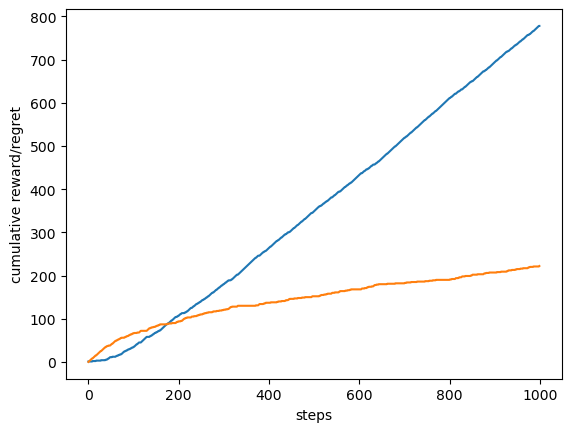

In [8]:
import matplotlib.pyplot as plt
plt.plot(cumulative_reward)
plt.plot(cumulative_regret)
plt.xlabel("steps")
plt.ylabel("cumulative reward/regret")
plt.show()

In [9]:
# average reward
print(sum(metrics["reward"][:100]) / 100)
print(sum(metrics["reward"][:1000]) / 1000)
print(sum(metrics["reward"][:10000]) / 10000)

print(sum(metrics["regret"][:100]) / 100)
print(sum(metrics["regret"][:1000]) / 1000)
print(sum(metrics["regret"][:10000]) / 10000)


0.34
0.778
0.8843
0.66
0.222
0.1157
